In [1]:
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
import seaborn as sns
plt.rcParams['lines.linewidth'] = 0.75

# Patient details file yaml/json
import yaml
from datetime import datetime, timedelta

import numpy as np
import pandas as pd

def df_repr_latex(self):
    return '\n'.join([
        r'\vspace{5mm}',
        r'{\scriptsize{\centering{%s}}}' % self.to_latex(),
        r'\vspace{5mm}'
    ])
pd.DataFrame._repr_latex_ = df_repr_latex
from pandas.io.formats.style import Styler
Styler._repr_latex_ = lambda s: s.data._repr_latex_()

class HTMLLatex:
    def __init__(self, html, latex):
        self.html = html
        self.latex = latex
    def _repr_html_(self): return self.html
    def _repr_latex_(self): return self.latex
NewPage = HTMLLatex('<hr>', r'\clearpage\newpage')

from IPython.display import display, HTML, Latex

from dcmfetch import fetch_series
from mriqa.reports import (
    ghosting_report, slice_profile_report, piqt_distortion_report,
    uniformity_report, snr_report, snr_report_multi, svs_report, fid_report,
    phase_background_report, fbirn_full_report, mtf_report
)
from mriqa.phantoms import PIQTSP
from mriqa.tools import show_montage, watermark
from mriqa.dcmio import qa_date, scanner_operator, larmor_frequency, software_versions

def show_test_result(passed):
    colour, status = 'green', 'ACCEPTABLE' if passed else 'red', 'FAILED'
    return HTMLLatex(
        f'<b>Test Result - <span style="color:{colour}">{status}</span></b>',
        f'\\textbf{{Test Result -- \\color{{{colour}}}{status}}}'
    )

# Watermark
wm = watermark()
display(pd.DataFrame(
    {'Watermark': list(wm.values())},
    index=wm.keys()
))

Watermark
CalculationTime  2022-04-20T16:48:06+01:00
User                        birchhub/rtrhd
PythonVersion                CPython 3.9.9
Platform          Linux 4.15.0-159-generic
mriqa                               0.2.11
dcmextras                            0.2.6
pydicom                              2.2.2
scipy                                1.7.3
numpy                               1.22.0
skimage                             0.19.1
matplotlib                           3.5.1

# Summary
Tests Performed:

- Slice shape and Profile
- Distortion and Field of View
- Resolution
- Ghosting
- Head Coil Image Uniformity

----

All of the above are acceptable.

----

In [2]:
NewPage

### Details of series to analyse.
The Patient ID, the Study ID and the Series Numbers of the QA scans.

In [3]:
with open('study.yml') as fp:
    study_info = yaml.safe_load(fp)

patid, studyid = study_info['PatID'], study_info.get('StudyID', '1')
tests = study_info['Tests']
for k, test in tests.items():
    if 'PatID' not in test:
        test['PatID'] = patid
    if 'StudyID' not in test:
        test['StudyID'] = studyid
series = tests['SliceProfile_PIQT']['Series']['3mm']

d = fetch_series(patid, studyid, sernos=series, imagesonly=True)[0]
scanner, date_of_scan, operator = d.StationName, qa_date(d), scanner_operator(d, 'BIRCH')

display(
    pd.DataFrame(
        {'Details':[scanner, date_of_scan, patid, studyid]}, 
        index=['Scanner', 'Date', 'Patient', 'Study']
    )
)

Details
Scanner              MRL1R1
Date               20190716
Patient  AQA20190716NBTMR11
Study                  4190

In [4]:
text = f'''
{operator}
Medical Physics & Bioengineering, UH Bristol
{datetime.strptime(date_of_scan, '%Y%m%d').strftime('%B %Y')}
'''

display(HTMLLatex(
    r'<pre>' + text + r'</pre>',
    r'\vfill' + '\n' + r'\begin{verbatim}' + '\n' + text + '\n' + r'\end{verbatim}' + '\n'
))

## Slice Profile

These are the profiles of 3mm and 5mm slices in a conventional spin echo using the crossed _slice profile_ slots in the PIQT phantom.

### 3 mm Slice

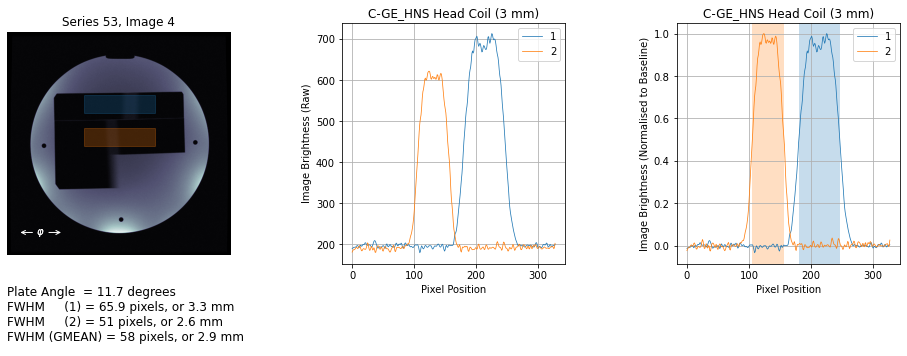

In [5]:
# TO2: Slice 3mm
info = tests['SliceProfile_PIQT']
series, slice_idx = info['Series']['3mm'], info['Slice']['3mm']

# Distortion Corrected, Phase RL, Non-Uniformity Corrected 512*512
dobjs = fetch_series(patid, studyid, sernos=series)
results = slice_profile_report(dobjs[slice_idx], phantom=PIQTSP, flipped_ud=False, flipped_rl=False)

### 5 mm Slice

In [6]:
# TO2: Slice 5mm
# Distortion Corrected, Phase RL, Non-Uniformity Corrected 512*512
info = tests['SliceProfile_PIQT']
series, slice_isx = info['Series']['5mm'], info['Slice']['5mm']
dobjs = fetch_series(patid, studyid, sernos=series)
result = slice_profile_report(dobjs[slice_idx], phantom=PIQTSP, flipped_ud=False, flipped_rl=False)
results = results.append(result)

In [7]:
pd.set_option('precision', 1)
results[['FWHMGMeanPixels', 'FWHMGMeanMM']].rename(columns={
    'FWHMGMeanPixels': 'Projected FWHM (pixels)',
    'FWHMGMeanMM': 'True FWHM (mm)'
})

Projected FWHM (pixels)  True FWHM (mm)
SliceThickness                                         
3.0                                58.0             2.9
5.0                                93.9             4.7

The profile widths are well within the AAPM tolerance of 0.5mm.

In [8]:
NewPage

## Image Scaling and Geometric Distortion

The PIQT phantom has a a grid of objects for scale and distortion measurements in plane. The scale reflects the Gradient Sensitivity calibration performed by the manufacturer as part of the system installation. These results are after applying tha manufacturer's distortion correction.

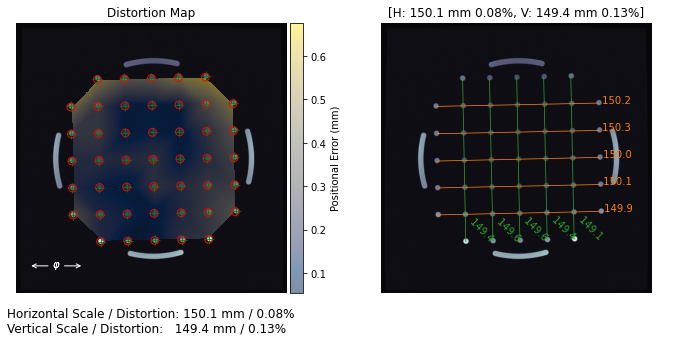

In [9]:
# PIQT: Distortion
info = tests['Distortion_PIQT']
patid, studyid = info['PatID'], info['StudyID']
series, slices = info['Series'], info['Slice']

# SE: Axial, Phase RL, 512 matrix
dobj = fetch_series(patid, studyid, sernos=series['AxialRL_Corrected'])[slices['AxialRL_Corrected']]
results = piqt_distortion_report(dobj)

In [10]:
pd.set_option('precision', 3)
results[[
    'Orientation', 'PhaseDirection', 'Sensitivity',
    'HorizontalScale', 'HorizontalDistortion',
    'VerticalScale', 'VerticalDistortion'
]].rename(columns={
    'PhaseDirection': 'Phase Direction',
    'HorizontalScale': 'Horizontal Scale (mm)', 'HorizontalDistortion':'Horizontal Distortion',
    'VerticalScale': 'Vertical Scale (mm)', 'VerticalDistortion': 'Vertical Distortion'  
})

Orientation Phase Direction  Sensitivity  Horizontal Scale (mm)  \
Series                                                                   
53           Axial              RL        0.255                150.094   

        Horizontal Distortion  Vertical Scale (mm)  Vertical Distortion  
Series                                                                   
53                      0.078              149.415                0.129

The scale in both the RL and AP directions are well within 1% at the bandwidth used (130Hz/pixel).

In [11]:
NewPage

## Resolution

Image resolution estimated by analysis of the mtf block in PIQT phantom.

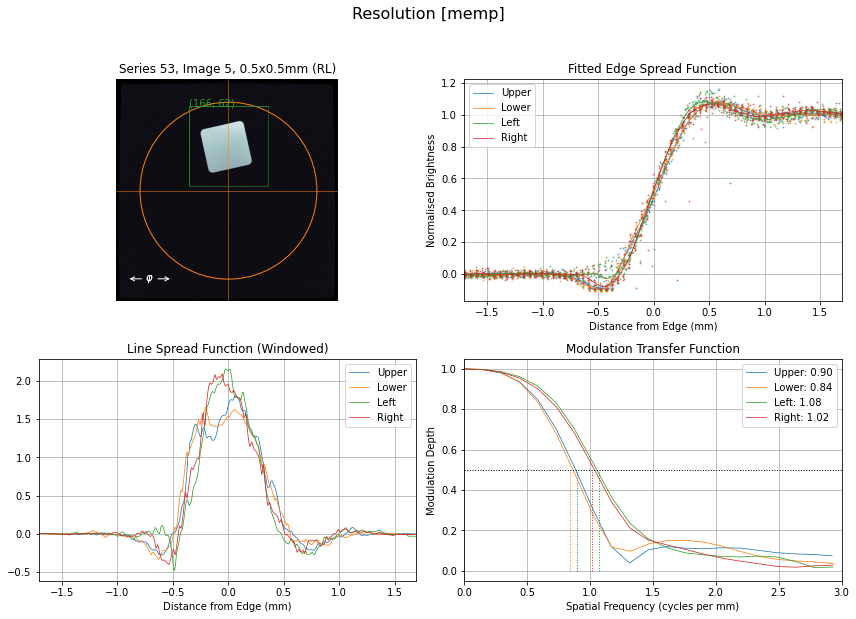

MTF_50
Upper   0.895
Lower   0.839
Left    1.076
Right   1.018

In [12]:
# PIQT: Resoution/MTF
info = tests['Resolution_PIQT']
patid, studyid = info['PatID'], info['StudyID']
series, slices = info['Series'], info['Slice']

# SE: Axial, Phase RL, 512 matrix
dobjs = sorted(fetch_series(patid, studyid, sernos=[series['SE512']]), key=lambda d: int(d.InstanceNumber))
dobj_mtf, dobj_centre = dobjs[slices['MTF']], dobjs[slices['Centre']]

results = mtf_report(dobj_mtf, dobj_centre)
plt.show()
results

The MTF_50 is consistent with a pixel size of 0.5mm along the left and right edges of the mtf block but is a little lower than expected across the upper and lower edges. This may imply a slightly degraded resolution in the frequency encode direction or may be a twist in the phantom alignment.

In [13]:
NewPage

## Ghosting

Image ghosting is assessed following the approach of [AAPM report 100](https://www.aapm.org/pubs/reports/RPT_100.pdf) for the transverse orientation and four example sequences.

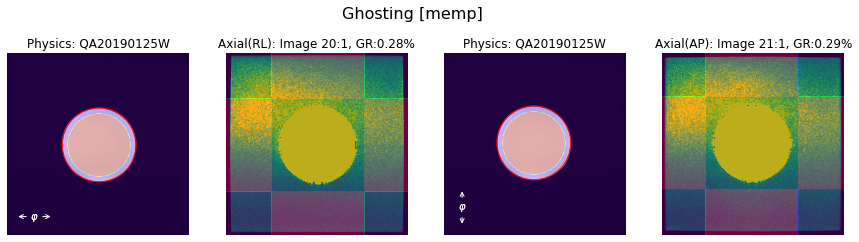

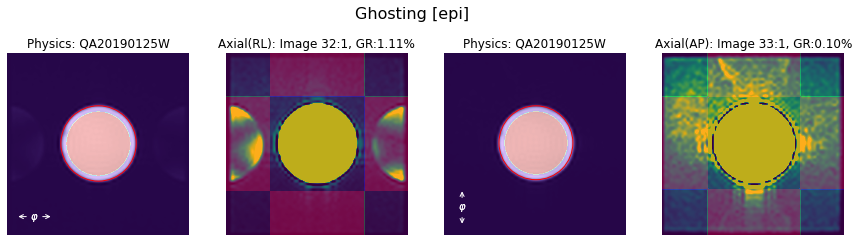

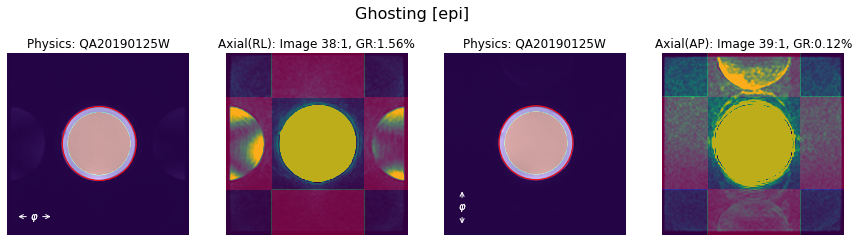

Sequence Orientation Phase Direction  Ghost Ratio (%)
Series                                                      
20         memp       Axial              RL            0.277
21         memp       Axial              AP            0.292
26       fse-xl       Axial              RL            1.028
27       fse-xl       Axial              AP            0.866
32          epi       Axial              RL            1.107
33          epi       Axial              AP            0.097
38          epi       Axial              RL            1.562
39          epi       Axial              AP            0.118

In [14]:
# GE10CM: Ghosting
info = tests['Ghosting_GE10']
patid, stuid = info['PatID'], info['StudyID']
series = info['Series']

# SE Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in series['SE']]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = ghosting_report(dobjs, axes=list(axs.flat))

# TSE18 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in series['TSE']]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))

# EPI64 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in series['EP2D']]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))
plt.show()

# EPISE128 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in series['EPSE']]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))
plt.show()

with pd.option_context('display.precision', 3):
    display(
        results[['Sequence', 'Orientation', 'PhaseDirection', 'GhostRatio']].rename(columns={
            'PhaseDirection': 'Phase Direction', 'GhostRatio': 'Ghost Ratio (%)'
        })
    )

The level of ghosting is over 1% for some of the sequences measured here including the EPIs. This seems to be noticable with the phase encoding direction right-left. There are ghosts in other than the Nyquist position. In addition, there are some non ghost-like patterns in the noise background that suggest some form of non-linear image filtering.

In [15]:
NewPage

## Receiver Coil Uniformity

We have tested the uniformity of the head coil using a spherical phantom filled with silicone oil. Results are presented both before and after coil sensitivity map based intensity normalisation.

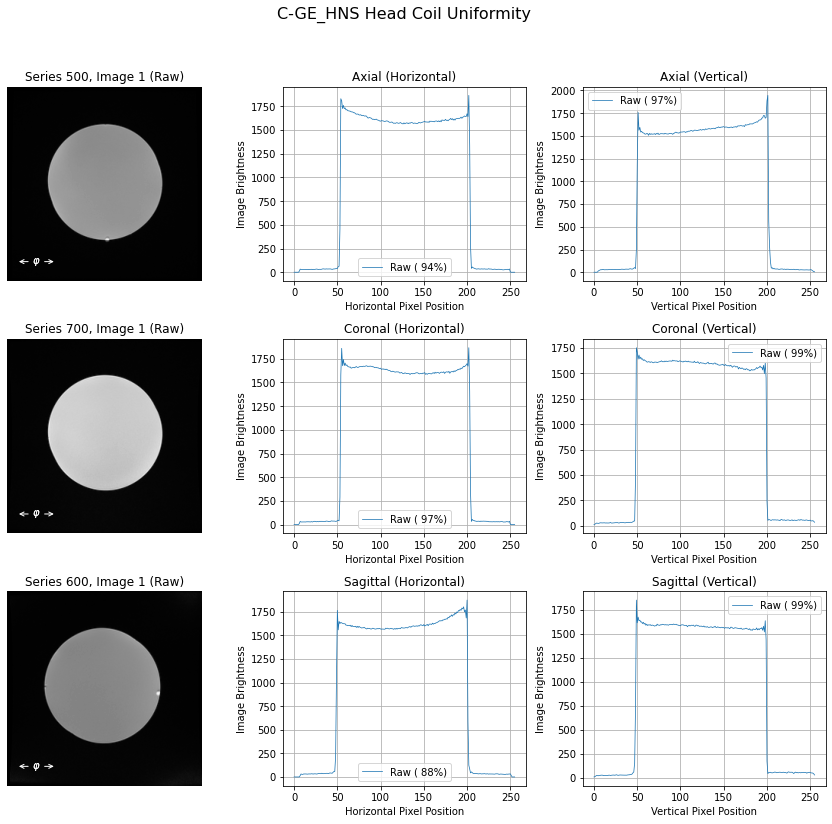

Series No.                Protocol         Axis  \
Orientation                                                    
Axial               500  Physics: QA20190125WIP     Axial/RL   
Coronal             700  Physics: QA20190125WIP   Coronal/RL   
Sagittal            600  Physics: QA20190125WIP  Sagittal/AP   

              X Uniformity (%)  Y Uniformity (%)  
Orientation                                       
Axial                    94.04             96.73  
Coronal                  97.33             99.34  
Sagittal                 88.24             98.68

In [16]:
# OILSPHERE: Uniformity
# SE Axial,Coronal,Sagittal; w w/o Intensity Normalization
info = tests['Uniformity_Oil']
patid, stuid = info['PatID'], info['StudyID']
series = info['Series']

raw_tra = fetch_series(patid, stuid, sernos=series['Axial'][0])
raw_sag = fetch_series(patid, stuid, sernos=series['Sagittal'][0])
raw_cor = fetch_series(patid, stuid, sernos=series['Coronal'][0])
results = uniformity_report(
    raw_dobjs=[raw_tra[0], raw_sag[0], raw_cor[0]]
)

plt.show()

with pd.option_context('display.precision', 2):
    display(
        results[['SeriesRaw',  'ProtocolRaw',  'OrientRaw', 'XUniformityRaw', 'YUniformityRaw']].rename(columns={
            'SeriesRaw': 'Series No.', 'ProtocolRaw': 'Protocol', 'OrientRaw': 'Axis',
            'XUniformityRaw': ' X Uniformity (%)', 'YUniformityRaw': 'Y Uniformity (%)'
        })
    )

From the degree of uniformity it would appear that these images have been intensity corrected. There were no uncorrected images for comparison. The residual non-uniformity is acceptable.

In [17]:
NewPage

### System Reference Values
These are the reference values reported in the DICOM header of a SE scan.

In [18]:
info = tests['TuneupParams']
patid, studyid, series = info['PatID'], info['StudyID'], info['Series']
series = info['Series']

dobj = fetch_series(patid, studyid, sernos=series)[0]
pd.DataFrame({
    'SoftwareVersions': [software_versions(dobj)],
    'ImagingFrequency': [larmor_frequency(dobj)]
}, index=['Value']).T

Value
SoftwareVersions  27:LX:MR Software release:DV25.1_R03_1802.a
ImagingFrequency                                        63.86